<h1><center>Black Friday: Purchase Prediction</center></h1>
<p><center>Predicting <b>Purchase</b> amount for Black Friday data.</center></p>
<p><center>Tools used: <b>Pandas, Numpy, Matplotlib, Seaborn, Scikit-learn, Dython</b></center><p/>
<p><center>Sections:</center></p>
<p><center> 
    <a href="#Exploratory-Data-Analysis">
        Exploratory Data Analysis
    </a>
</center></p>

<p><center> 
    <a href="#Preprocessing-and-Feature-Selection">
        Preprocessing and Feature Selection
    </a>
</center></p>

<p><center>
    <a href="#Model-Building-and-Evaluation">
        Model Building and Evaluation
    </a>
</center></p>

<p><center>
    <a href="#Final-Prediction">
        Final Prediction
    </a>
</center></p>

---

# Exploratory Data Analysis

Importing the libraries and modules that we will be using:

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from dython import nominal # For Categorical Correlation

Importing the **train** and the **test** sets and taking a look at their dataframes:

In [95]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
print(train_df.shape)
train_df.head()

(550068, 12)


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [4]:
print(test_df.shape)
test_df.head()

(233599, 11)


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
0,1000004,P00128942,M,46-50,7,B,2,1,1,11.0,NaN
1,1000009,P00113442,M,26-35,17,C,0,0,3,5.0,NaN
2,1000010,P00288442,F,36-45,1,B,4+,1,5,14.0,NaN
3,1000010,P00145342,F,36-45,1,B,4+,1,4,9.0,NaN
4,1000011,P00053842,F,26-35,1,C,1,0,4,5.0,12.0


Looking at the **percentage of null values** for every column in the datasets:

In [5]:
print(f'Percentage of train nulls: \n\n{(train_df.isnull().sum()/train_df.shape[0])*100}\n\n')
print(f'Percentage of test nulls: \n\n{(test_df.isnull().sum()/test_df.shape[0])*100}')

Percentage of train nulls: 

User_ID                        0.000000
Product_ID                     0.000000
Gender                         0.000000
Age                            0.000000
Occupation                     0.000000
City_Category                  0.000000
Stay_In_Current_City_Years     0.000000
Marital_Status                 0.000000
Product_Category_1             0.000000
Product_Category_2            31.566643
Product_Category_3            69.672659
Purchase                       0.000000
dtype: float64


Percentage of test nulls: 

User_ID                        0.000000
Product_ID                     0.000000
Gender                         0.000000
Age                            0.000000
Occupation                     0.000000
City_Category                  0.000000
Stay_In_Current_City_Years     0.000000
Marital_Status                 0.000000
Product_Category_1             0.000000
Product_Category_2            30.969311
Product_Category_3            69.590195
dtype:

**Observation:** The `Product_Category_3` column has an extremely high number of nulls for both datasets. Therefore, to follow best practice, we are simply going to **remove it** later on, as trying to artificially fill it will only have a negative impact on our model's performance.

---

We are now going to define a function for visualizing the **correlations** between the columns of our datasets. I am using the **Nominal** module from **Dython** here instead of the pandas function, "df.**corr()**", as unlike pandas, nominal also includes the correlation between **categorical** variables:

In [6]:
def cat_corr(df,columns):
    from dython import nominal
    import matplotlib.pyplot as plt
    import warnings
    
    size = ((20,10) if 'all' in columns else (5,7))
    warnings.filterwarnings("ignore")
    nominal.associations(df,figsize=size,mark_columns=True, display_columns=columns,\
                         title="Correlation Matrix")
    plt.show()

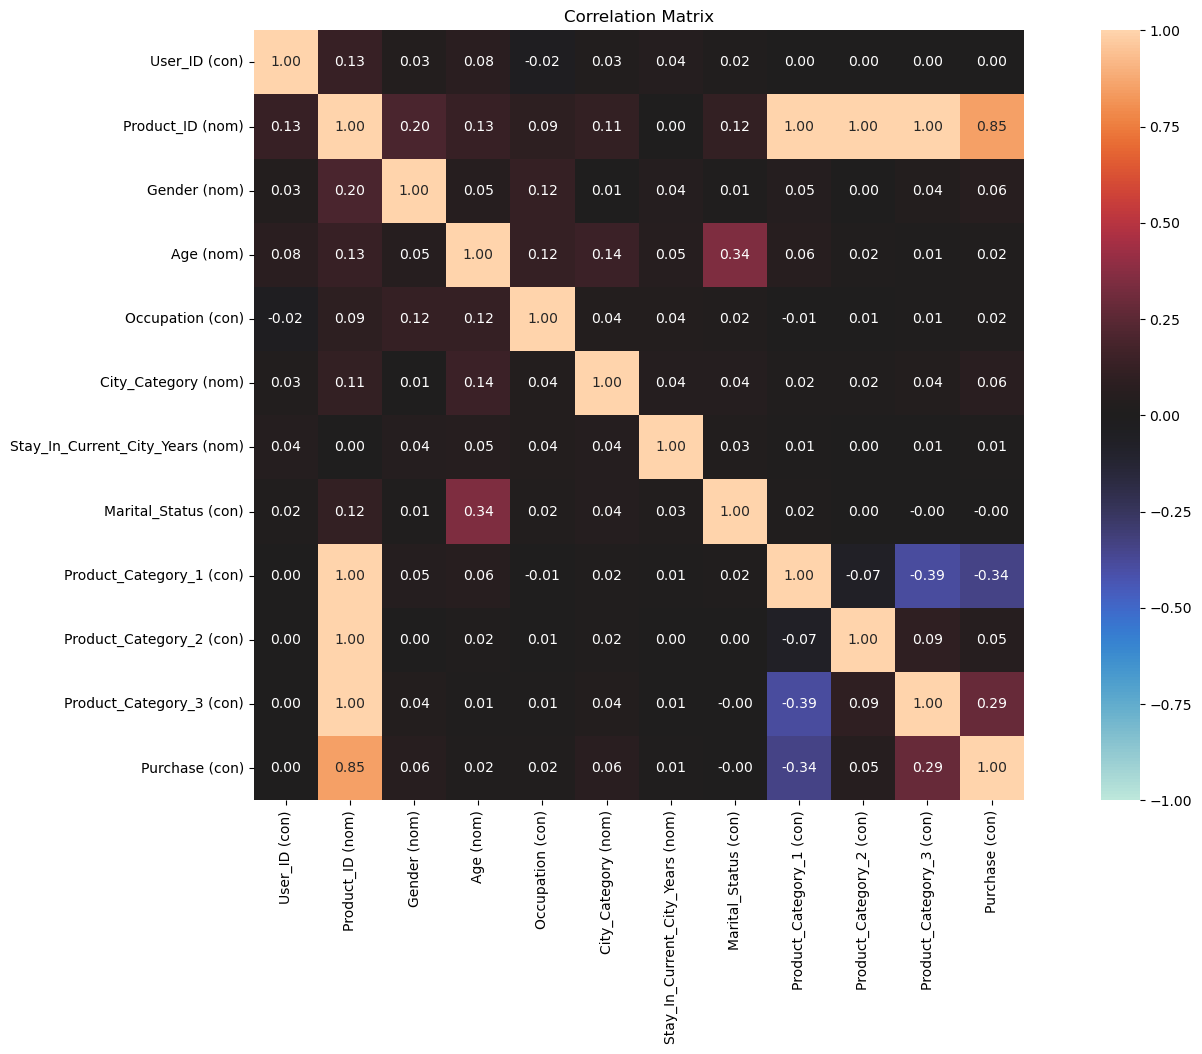

In [9]:
cat_corr(train_df,'all')

Now we can see the correlations between all of the columns in our dataset.

But if we want to view the correlations for just one of the columns; for example, our target column, `Purchase`, we can simply view it by inputting the name of the column after the name of the dataframe, like this:

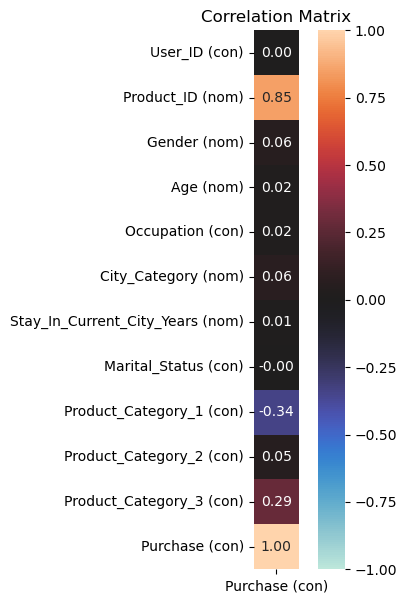

In [10]:
cat_corr(train_df,'Purchase')

**Observations:** `Product_Category_1` has the highest correlation among the features, and that too negatively. Which means that: 
* **The more amount someone has bought of the product in category 1, the less the total purchase tends to be**. Something similar can be seen with `Product_Category_3`.

From the ccorrelations between all three product columns, we can also see that: 

* **The more someone has bought of one specific product, the less likely they are to buy the other products**, *except for the products in `Product_Category_2`.*

These observations could imply that the products in `Product_Category_2` may be some sort of neccessity, or very much in demand; so that spending money on other things does not make it less likely for customers to spend money on buying them as well.

The negative correlation between products 1 and 3 could imply that the people looking to buy one of them are not necessarily looking to buy the other. Maybe because the products are somewhat similar? Still, **we have to keep in mind that more than half the data on product 3 is missing! So, it might be the case they aren't negatively correlated at all**.

---

Now, let's take a deeper look at the columns and decide what we want to do with them.

In [46]:
train_df.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

In [43]:
train_df.dtypes

User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Purchase                        int64
dtype: object

In [39]:
train_df.Marital_Status.value_counts() # Make boolean

0    324731
1    225337
Name: Marital_Status, dtype: int64

In [40]:
train_df.Occupation.value_counts() # Nothing

4     72308
0     69638
7     59133
1     47426
17    40043
20    33562
12    31179
14    27309
2     26588
16    25371
6     20355
3     17650
10    12930
5     12177
15    12165
11    11586
19     8461
13     7728
18     6622
9      6291
8      1546
Name: Occupation, dtype: int64

In [41]:
train_df.Age.value_counts() # Nothing

26-35    219587
36-45    110013
18-25     99660
46-50     45701
51-55     38501
55+       21504
0-17      15102
Name: Age, dtype: int64

In [42]:
train_df.Stay_In_Current_City_Years.value_counts() # Nothing

1     193821
2     101838
3      95285
4+     84726
0      74398
Name: Stay_In_Current_City_Years, dtype: int64

In [13]:
train_df.Product_Category_2.value_counts() # Fill with either the mode or the average of 8 and 14 (11)

8.0     64088
14.0    55108
2.0     49217
16.0    43255
15.0    37855
5.0     26235
4.0     25677
6.0     16466
11.0    14134
17.0    13320
13.0    10531
9.0      5693
12.0     5528
10.0     3043
3.0      2884
18.0     2770
7.0       626
Name: Product_Category_2, dtype: int64

Now that we have decided, it is time for **processing** the data.

---

# Preprocessing and Feature Selection

We are going to define a function that will perform all the things we have decided in the previous section on the columns:

In [20]:
def prepare(*args):
    for df in args:
        thresh = len(df)*.5
        df.dropna(thresh=thresh,axis=1,inplace=True) # Dropping columns with more than 50% null values
        df.Product_Category_2 = df.Product_Category_2.fillna(df.Product_Category_2.mode()[0]) # Filling nulls with mode
        df.Marital_Status = df.Marital_Status.astype('bool') #making column into bool

But first let's make a copy of our datasets:

In [96]:
train_df_2 = train_df.copy()
test_df_2 = test_df.copy()

Now we will "prepare" our sets:

In [97]:
prepare(train_df,test_df)

Let's check if it has worked:

In [22]:
print(f'Data types: \n\n{train_df.dtypes}\n\n')
print(f'Null counts: \n\n{train_df.isna().sum()}')

Data types: 

User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years     object
Marital_Status                   bool
Product_Category_1              int64
Product_Category_2            float64
Purchase                        int64
dtype: object


Null counts: 

User_ID                       0
Product_ID                    0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category_1            0
Product_Category_2            0
Purchase                      0
dtype: int64


It has done what we wanted.

Let's take a look at the correlations now:

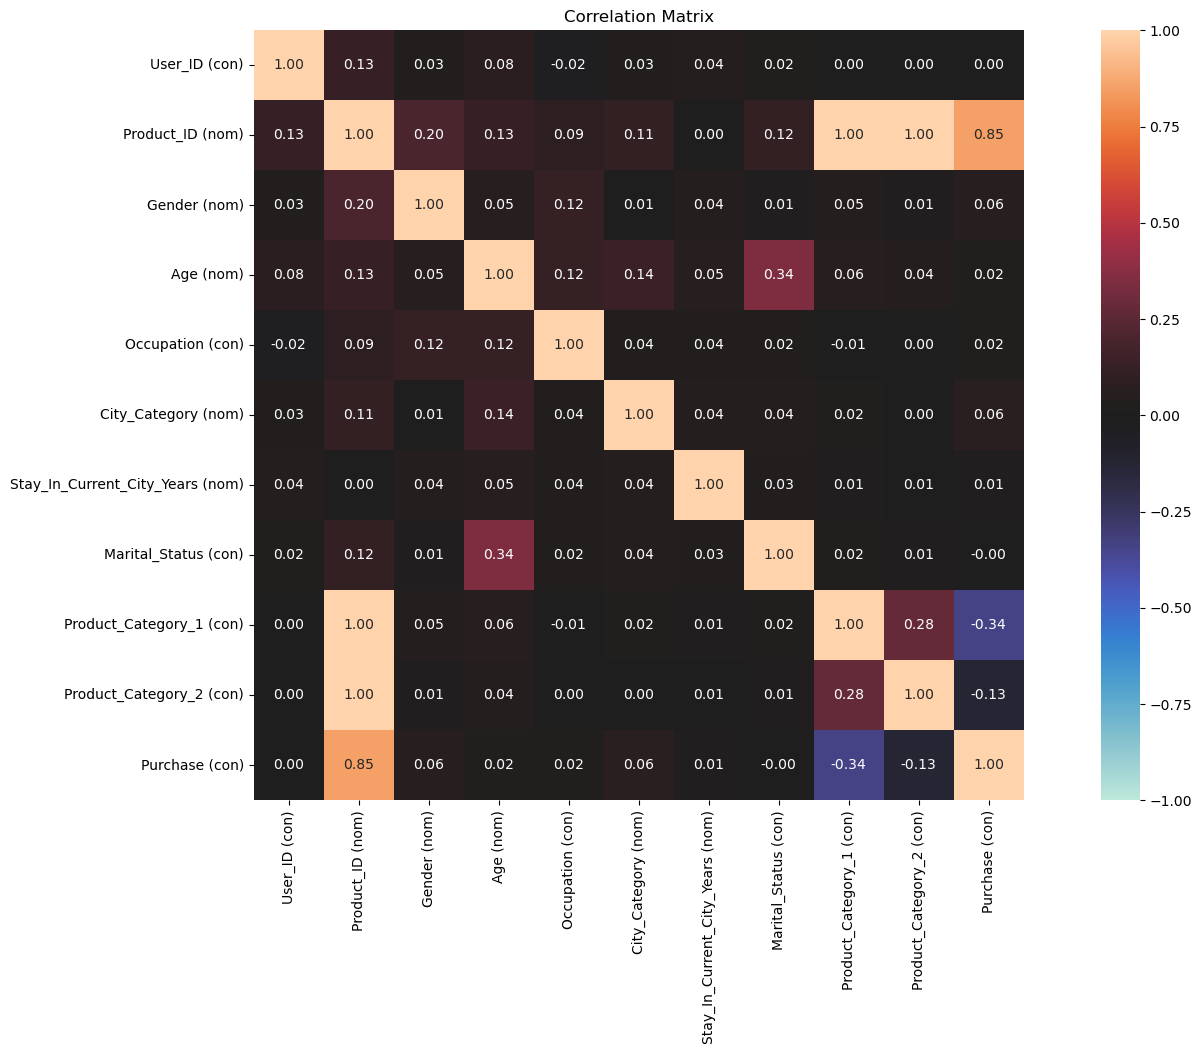

In [159]:
cat_corr(train_df,'all')

**Observation:** The correlation of `Product_Category_3` with `Purchase` seems to have increased. This might be good news.

Now lets select the features we want to use for the model:

In [81]:
train_df.columns

Index(['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Purchase'],
      dtype='object')

In [55]:
features = ['Gender', 'Age', 'Occupation', 'City_Category',
            'Stay_In_Current_City_Years', 'Marital_Status', 
            'Product_Category_1','Product_Category_2']

And split them into **independent** and **dependent** variables:

In [11]:
X = pd.get_dummies(train_df[features])
y = train_df.Purchase

Let's have a look at them now:

In [18]:
X.head()

,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Gender_F,Gender_M,Age_0-17,Age_18-25,Age_26-35,Age_36-45,...,Age_51-55,Age_55+,City_Category_A,City_Category_B,City_Category_C,Stay_In_Current_City_Years_0,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4+
0,10,False,3,8.0,1,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,10,False,1,6.0,1,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,10,False,12,8.0,1,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,10,False,12,14.0,1,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,16,False,8,8.0,0,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1


In [19]:
y.head()

0     8370
1    15200
2     1422
3     1057
4     7969
Name: Purchase, dtype: int64

Looks good. Time to move on to **model building**.

---

# Model Building and Evaluation

Importing **train_test_split** from scikit-learn for evalutaion:

In [12]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

Now we are going to fit our training and test splits:

In [13]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=1)

rf.fit(X_train, y_train)

RandomForestRegressor(random_state=1)

In [14]:
y_pred = rf.predict(X_test)

Let's write a function to score **Regression Models**. It will give us the model's **MSE**, **RMSE**, **MAE**, **MEDAE** and **MAPE**.

In [15]:
def rf_score(test, prediction):
    from sklearn import metrics
    mse = metrics.mean_squared_error(test, prediction)
    rmse = metrics.mean_squared_error(test,prediction,squared=False)
    mae = metrics.mean_absolute_error(test, prediction)
    medae = metrics.median_absolute_error(test, prediction)
    mape = metrics.mean_absolute_percentage_error(test, prediction)

    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Median Absolute Error (MEDAE): {medae}")
    print(f"Mean Absolute Percentage Error: {mape}")
    print(f'Test variance: {np.var(y_test)}')

And score our model:

In [16]:
rf_score(y_test, y_pred)

Mean Squared Error (MSE): 8996639.71591952
Root Mean Squared Error (RMSE): 2999.4399003679873
Mean Absolute Error (MAE): 2196.7562355442087
Median Absolute Error (MEDAE): 1628.0183837690083
Mean Absolute Percentage Error: 0.33049550994058147
Test variance: 25324807.738806877


---

Now we are going to build a model in which we input the nulls in `Product_Category_2` with the **average of the top 2 most frequent values**, instead of the **mode**. We calculated it earlier to be **11**.

In [56]:
def prepare2(*args):
    for df in args:
        thresh = len(df)*.5
        df.dropna(thresh=thresh,axis=1,inplace=True) # Dropping columns with more than 50% null values
        df.Product_Category_2 = df.Product_Category_2.fillna(11) # Filling nulls with average
        df.Marital_Status = df.Marital_Status.astype('bool') #making column into bool

And apply it to the copy we created earlier:

In [109]:
prepare2(train_df_2, test_df_2)

We repeat the steps for model building and evaluation:

In [99]:
X2 = pd.get_dummies(train_df_2[features])
y2 = train_df.Purchase

In [100]:
X2_train,X2_test,y2_train,y2_test = train_test_split(X2,y2,test_size=.2,random_state=1)

In [60]:
rf2 = RandomForestRegressor(random_state=1)

rf2.fit(X2_train,y2_train)

RandomForestRegressor(random_state=1)

In [61]:
y2_pred = rf2.predict(X2_test)

rf_score(y2_test ,y2_pred)

Mean Squared Error (MSE): 8983493.64806117
Root Mean Squared Error (RMSE): 2997.247678798195
Mean Absolute Error (MAE): 2195.05910380806
Median Absolute Error (MEDAE): 1630.1461221348118
Mean Absolute Percentage Error: 0.3301880720427081
Test variance: 25324807.738806877


**Observation:** The model built on the **average** of the top 2 values is **better** than the model built on just the **mode**. So, this is the model we will use for our final predictions.

In [64]:
residuals = y2_test - y2_pred
print(residuals.max())
print(residuals.min())
print(residuals.max() - residuals.min())

14723.774297619046
-17023.117221139968
31746.891518759014


Our model's full range of error is around **31,747**.

---

Let's visualize our residuals:

In [70]:
def plot_residual(test, prediction):
    residuals = test - prediction
    plt.scatter(np.arange(len(test)), residuals, c=residuals, cmap='magma', edgecolors='black', linewidths=.1)
    plt.colorbar(label="Error", orientation="vertical")
    plt.hlines(y = 0, xmin = 0, xmax=len(test), linestyle='--', colors='black')
    plt.xlim((test.min(), test.max()))
    plt.xlabel('Purchase'); plt.ylabel('Residuals')
    plt.show()

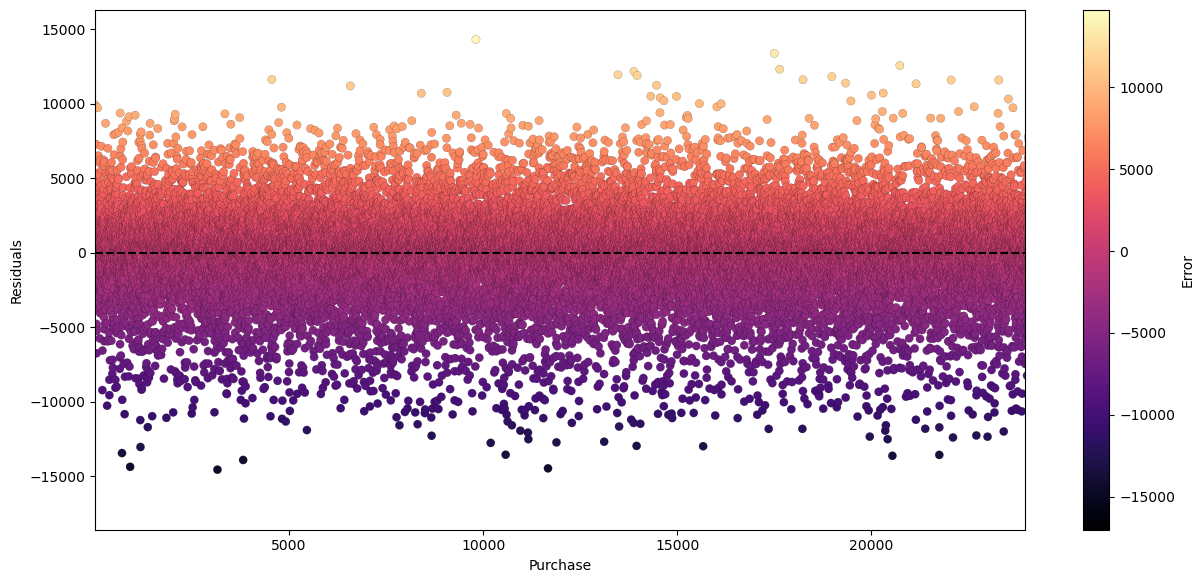

In [71]:
plot_residual(y2_test, y2_pred)

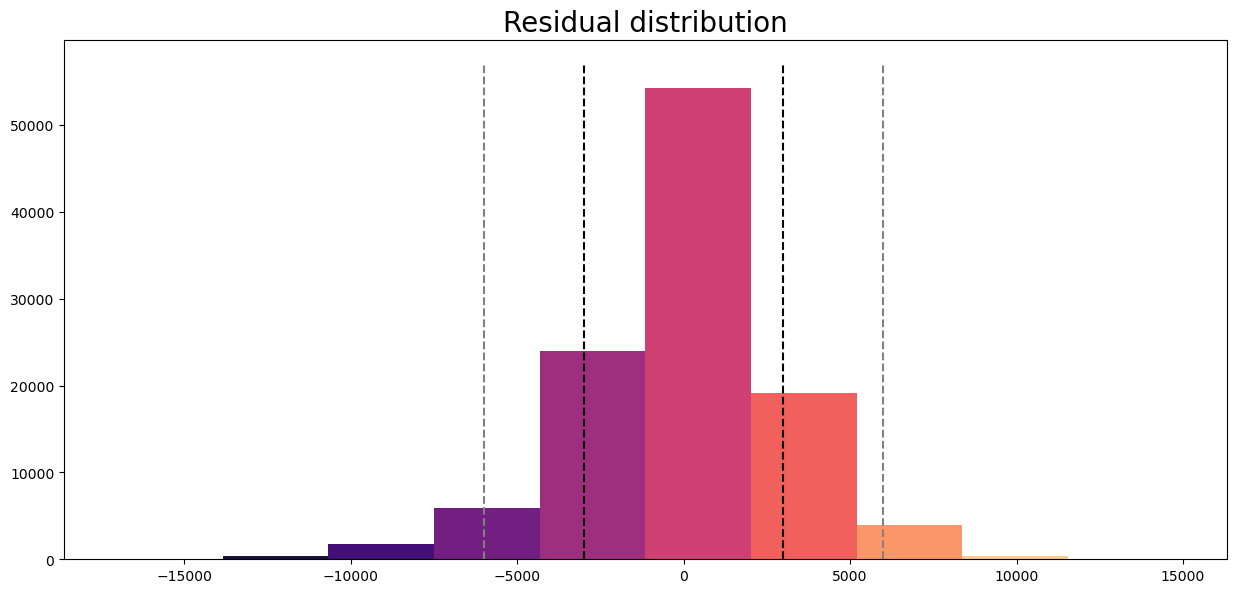

In [102]:
my_cmap = plt.get_cmap("magma")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
plt.rcParams["figure.figsize"] = (15,6.75)

n, bins, patches = plt.hist(residuals)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
col = bin_centers - min(bin_centers)
col /= max(col)
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', my_cmap(c))
plt.vlines(x = residuals.std(), ymin = 0, ymax=57000, linestyle='--', colors='black')
plt.vlines(x = -residuals.std(), ymin = 0, ymax=57000, linestyle='--', colors='black')
plt.vlines(x = residuals.std()*2, ymin = 0, ymax=57000, linestyle='--', colors='grey')
plt.vlines(x = -residuals.std()*2, ymin = 0, ymax=57000, linestyle='--', colors='grey')
plt.title('Residual distribution', fontsize=20)
plt.show()

In [103]:
print(residuals.std())
residuals.std()*2

2997.2520545448024


5994.504109089605

**Observation:** The distribution of our residuals is **normal**, so almost **70%** of our prediction results lie within just an error of around **3000**, while almost **96%** of our predictions lie within an error of around **6000**.

Now we will do our final predictions.

---


# Final Prediction

By splitting our training dataset's data into a train and test set, we have gotten a general idea on how the model might perform on real data. 

But for the final step, we will use **all** of the data in the training dataset to train the model. This way, it will have more data to train on and probably will have better predictions.

In [101]:
rf2.fit(X2,y2)

RandomForestRegressor(random_state=1)

In [104]:
test_df_pred = rf2.predict(pd.get_dummies(test_df_2[features]))

In [105]:
print(test_df_pred.shape)
test_df.shape

(233599,)


(233599, 10)

Now we are going to join our predictions as a new column in the test dataset:

In [106]:
test_df_pred = pd.DataFrame({'Purchase': test_df_pred})

In [107]:
final_df = pd.concat([test_df,test_df_pred],axis=1)

In [108]:
final_df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Purchase
0,1000004,P00128942,M,46-50,7,B,2,True,1,11.0,18104.409213
1,1000009,P00113442,M,26-35,17,C,0,False,3,5.0,10501.056810
2,1000010,P00288442,F,36-45,1,B,4+,True,5,14.0,8246.751493
3,1000010,P00145342,F,36-45,1,B,4+,True,4,9.0,2447.156333
4,1000011,P00053842,F,26-35,1,C,1,False,4,5.0,1808.537429


We can now export the results as a csv, and we are done.

---